In [3]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=2cd3208f215d932b7d89c4b4a3f4af54a07ce05b11796be4f02e65d0db7def44
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


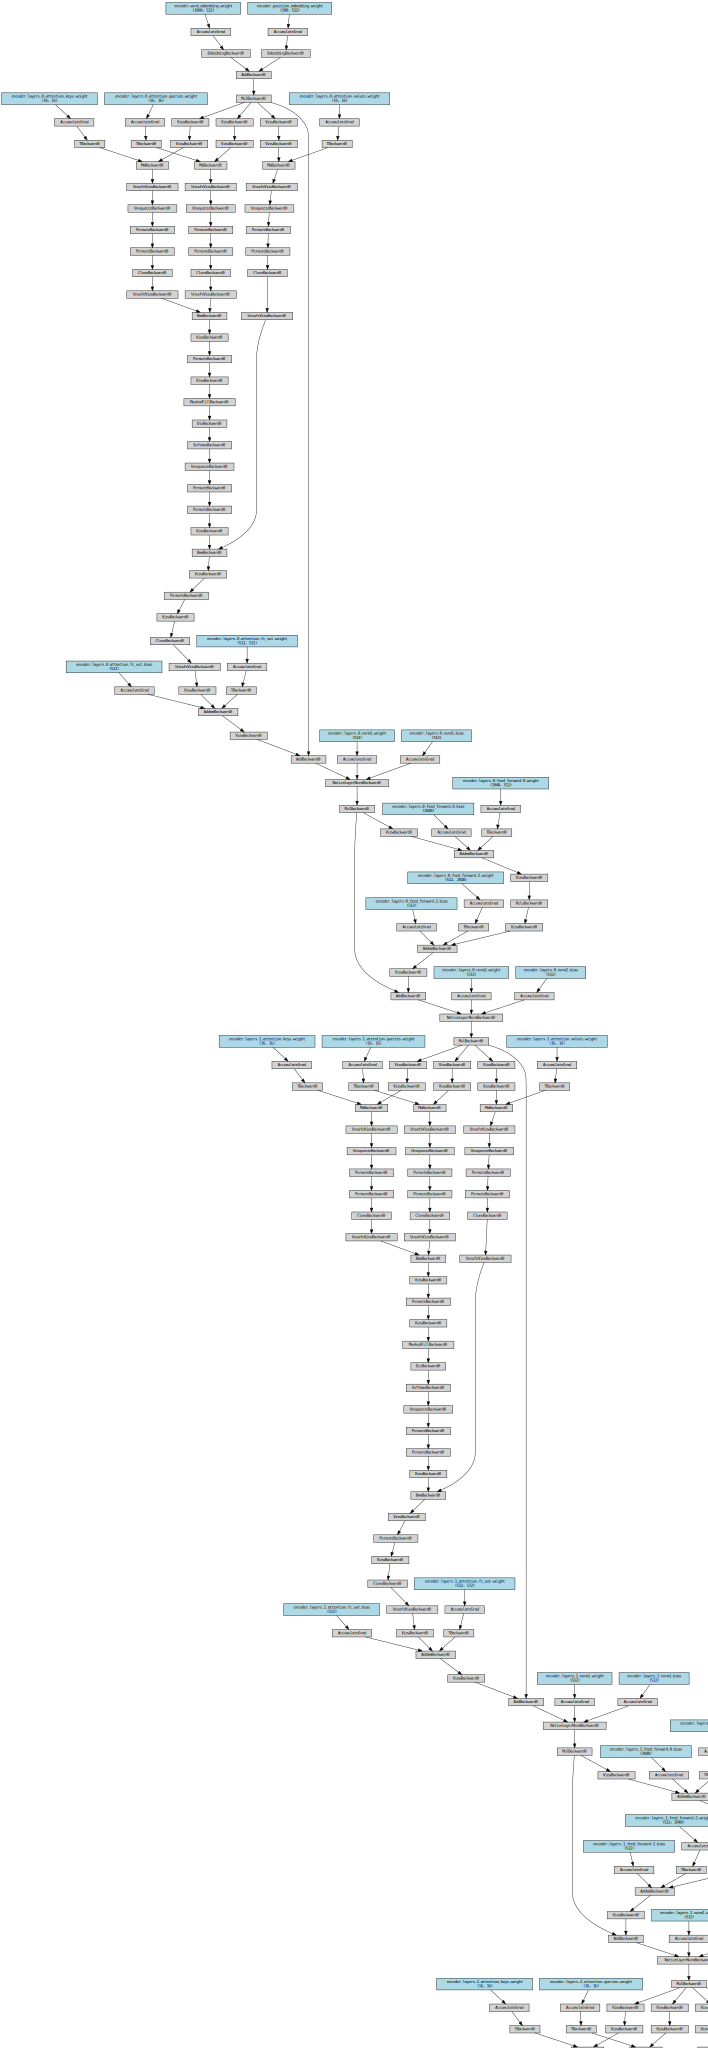

In [24]:
import torch
import torch.nn as nn
from torchviz import make_dot
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            mask = mask.unsqueeze(1)  # Add a singleton dimension for head
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        heads,
        device,
        forward_expansion,
        dropout,
        max_length,
    ):

        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(device)
        out = self.dropout(
            (self.word_embedding(x) + self.position_embedding(positions))
        )

        for layer in self.layers:
            out = layer(out, out, out, mask)

        return out

class Transformer(nn.Module):
    def __init__(
        self,
        src_vocab_size,
        embed_size,
        num_layers,
        forward_expansion,
        heads,
        dropout,
        max_length,
        device,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length,
        )

    def forward(self, src, mask):
        out = self.encoder(src, mask)
        return out

# Example usage
src_vocab_size = 1000
embed_size = 512
num_layers = 3
forward_expansion = 4
heads = 32
dropout = 0.1
max_length = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Transformer(
    src_vocab_size,
    embed_size,
    num_layers,
    forward_expansion,
    heads,
    dropout,
    max_length,
    device,
).to(device)

src = torch.randint(0, src_vocab_size, (32, 10)).to(device)
mask = torch.ones((32, 10)).to(device)

output = model(src, mask)
make_dot(output, params=dict(model.named_parameters()))

Epoch 1/10, Loss: 1.8026494719088078, Accuracy: 5.2
Epoch 2/10, Loss: 1.4796861447393894, Accuracy: 5.2
Epoch 3/10, Loss: 1.4692417532205582, Accuracy: 4.8
Epoch 4/10, Loss: 1.4710536673665047, Accuracy: 4.8
Epoch 5/10, Loss: 1.4915296845138073, Accuracy: 4.8
Epoch 6/10, Loss: 1.4402938596904278, Accuracy: 4.8
Epoch 7/10, Loss: 1.455035924911499, Accuracy: 4.8
Epoch 8/10, Loss: 1.3962015584111214, Accuracy: 5.2
Epoch 9/10, Loss: 1.427255418151617, Accuracy: 5.2
Epoch 10/10, Loss: 1.4460962489247322, Accuracy: 4.8


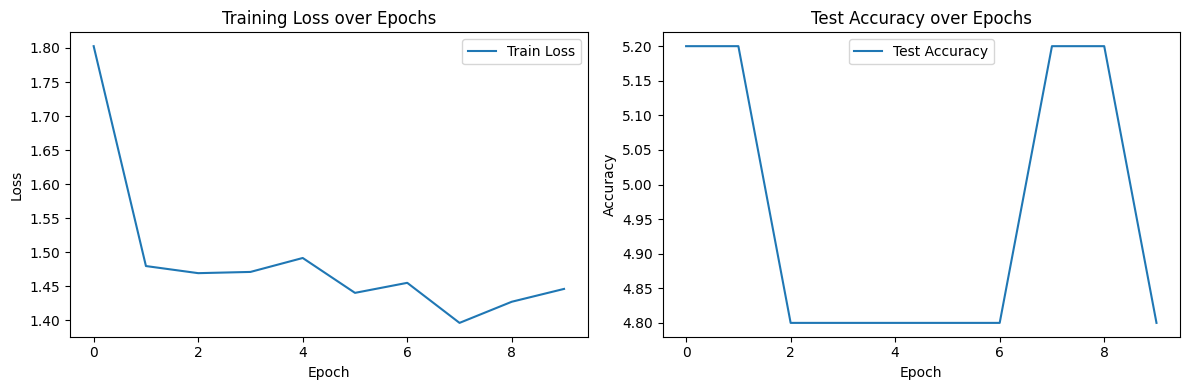

In [25]:
# Dummy dataset and labels (replace with your actual data)
src_vocab_size = 1000
embed_size = 512
num_layers = 3
forward_expansion = 4
heads = 32
dropout = 0.1
max_length = 100

train_data = torch.randint(0, src_vocab_size, (1000, 10))
train_labels = torch.randint(0, 2, (1000,))

test_data = torch.randint(0, src_vocab_size, (200, 10))
test_labels = torch.randint(0, 2, (200,))

# Define dataset and dataloaders
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Transformer model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(
    src_vocab_size,
    embed_size,
    num_layers,
    forward_expansion,
    heads,
    dropout,
    max_length,
    device,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Lists to store training progress
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)

        # Forward pass
        output = model(data, mask=None)

        labels_expanded = labels.unsqueeze(1).expand(-1, data.shape[1])
        loss = criterion(output.permute(0, 2, 1), labels_expanded)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    average_train_loss = epoch_loss / len(train_loader)
    train_losses.append(average_train_loss)

    # Evaluate on the test set
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            output = model(data, mask=None)
            _, predicted = torch.max(output, 2)

            total_samples += labels.numel()
            total_correct += (predicted == labels[0]).sum().item()

        accuracy = total_correct / total_samples
        test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_train_loss}, Accuracy: {accuracy}")

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()